# Transfer Learning 
### Creating a transfer learning model with VGG16

In [1]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.applications import VGG16
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from IPython.display import clear_output

Using TensorFlow backend.


In [2]:
base_model=VGG16(weights='imagenet',include_top=False) #imports the VGG model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(3,activation='softmax')(x) #final layer with softmax activation

In [3]:
model=Model(inputs=base_model.input,outputs=preds)
#model.load_weights("output_transf_muliclass/new_dataset_model/weights001.h5")
for i,layer in enumerate(model.layers):
  print(i,layer.name)


0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 global_average_pooling2d_1
20 dense_1
21 dense_2
22 dense_3
23 dense_4


In [4]:
model.layers[23]

In [5]:
for layer in model.layers:
    layer.trainable=False
# or if we want to set the first 20 layers of the network to be non-trainable
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [6]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory('data2/train/',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode="categorical",
                                                 shuffle=True)


Found 1113 images belonging to 3 classes.


In [7]:
filepath="output_transf/new_dataset_model/weights-improvement-{epoch:02d}.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
mc = keras.callbacks.ModelCheckpoint('output_transf_muliclass/new_dataset_model/weights{epoch:03d}.h5', 
                                     save_weights_only=True, period=1)

In [8]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',
              metrics=['accuracy'])


In [9]:
val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

val_generator=val_datagen.flow_from_directory('data2/validation/',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=1,
                                                 class_mode="categorical",
                                                 shuffle=False)
# 0 > Not stocked
# 1 > Other
# 2 > Stocked

Found 187 images belonging to 3 classes.


In [10]:
step_size_train=train_generator.n//train_generator.batch_size
vgg16_fit = model.fit_generator(generator=train_generator,
                               steps_per_epoch=step_size_train,
                               epochs=3,
                                callbacks = [mc])

Epoch 1/3
34/34 [==============================] - 9586s 282s/step - loss: 0.6995 - acc: 0.6853
Epoch 2/3
34/34 [==============================] - 9859s 290s/step - loss: 0.4029 - acc: 0.8339
Epoch 3/3
34/34 [==============================] - 11034s 325s/step - loss: 0.3342 - acc: 0.8540


In [11]:
import matplotlib.pyplot as plt

%matplotlib inline

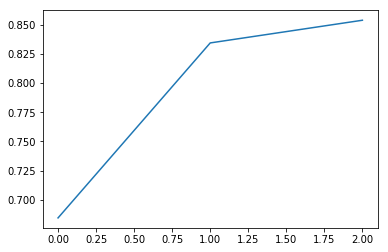

In [12]:
loss = vgg16_fit.history['acc']
#val_loss = vgg16_fit.history['val_loss']
plt.plot(loss)
#plt.plot(val_loss)
#plt.legend(['loss', 'val_loss'])
plt.show()

In [13]:
#model.save_weights("VGG16_transfer_adam_b_crossentropy.h5")

In [14]:
val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

val_generator=val_datagen.flow_from_directory('data2/validation/',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=1,
                                                 class_mode='categorical',
                                                 shuffle=False)

Found 187 images belonging to 3 classes.


In [15]:
filenames = val_generator.filenames
nb_samples = len(filenames)

In [16]:
loss, acc = model.evaluate_generator(val_generator, steps=nb_samples, verbose=0)

In [17]:
loss,acc 

(0.6669987248316177, 0.7754010695187166)

In [18]:
model_json = model.to_json()
with open("output_transf_muliclass/new_dataset_model/new_final.json", "w") as json_file:
    json_file.write(model_json)
model.save("output_transf_muliclass/new_dataset_model/new_final2.h5")

In [19]:
model.load_weights("output_transf_muliclass/new_dataset_model/weights002.h5")

In [20]:
loss, acc = model.evaluate_generator(val_generator, steps=nb_samples, verbose=0)
loss,acc #First 10 epochs

(0.5624859611264724, 0.7754010695187166)

In [21]:
model.save("output_transf_muliclass/new_dataset_model/new_final2.h5")

In [1]:
# =======================================


In [2]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D

from keras.applications import VGG16

from keras.models import Model

from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.engine import InputLayer
import cv2
import glob


Using TensorFlow backend.


In [3]:
IMAGE_SIZE = 105
EPSILON = 0.02


In [4]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.engine import InputLayer
import keras

def to_fully_conv(model):
    """
    This function converts fully connencted layers into convolutional layers for localization.
    
    """
    new_model = Sequential()

    #input_layer = InputLayer(input_shape=(None, None, 3), name="input_new")

    #new_model.add(input_layer)

    for layer in model.layers:
        print(layer)
        if "GlobalAveragePooling2D" in str(layer):
            flattened_ipt = True
            f_dim = layer.input_shape

        elif "Dense" in str(layer):

            input_shape = layer.input_shape
            output_dim =  layer.get_weights()[1].shape[0]
            W,b = layer.get_weights()

            if flattened_ipt:
                shape = (f_dim[1],f_dim[2],f_dim[3],output_dim)
                new_W = W.reshape(shape)
                new_layer = Convolution2D(output_dim,
                                          (f_dim[1],f_dim[2]),
                                          strides=(1,1),
                                          activation=layer.activation,
                                          padding='valid',
                                          weights=[new_W,b])
                flattened_ipt = False

            else:
                shape = (1,1,input_shape[1],output_dim)
                new_W = W.reshape(shape)
                new_layer = Convolution2D(output_dim,
                                          (1,1),
                                          strides=(1,1),
                                          activation=layer.activation,
                                          padding='valid',
                                          weights=[new_W,b])
        else:
            new_layer = layer
            
        new_model.add(new_layer)
        flattened_ipt = False
    return new_model

In [5]:
example_not_stocked = "data/train/Not_Stocked/not_stocked_0_2371.jpeg"
img_not_stocked = cv2.imread(example_not_stocked)
img_not_stocked = cv2.cvtColor(img_not_stocked, cv2.COLOR_BGR2RGB)
plt.imshow(img_not_stocked)

error: OpenCV(3.4.2) /opt/concourse/worker/volumes/live/0851a95b-0a19-4f3a-61a7-502b925fea13/volume/opencv-suite_1535642710601/work/modules/imgproc/src/color.hpp:253: error: (-215:Assertion failed) VScn::contains(scn) && VDcn::contains(dcn) && VDepth::contains(depth) in function 'CvtHelper'


In [6]:
def process_pred_img(img, w = 105, h = 105):
    img = cv2.resize(img,(h,w))
    img = img.reshape(1,w,h,3)
    return(img)

In [9]:

def localizee(model,filepath = "", W = 300, H = 300, less = True):
    """
    This function iterates through scales for a fixed w, h image and gets a heatmap. 
    The function return a list of bounding over the scales.
    It thresholds the heatmap at .7, and appends to a list.
    This function follows from: https://github.com/lars76/object-localization/blob/master/example_3/test.py
    """
    scales = np.arange(0.3,1.1, 0.1) #[0.3, 0.4,..., 0.9, 1.0]
    list_of_heatmaps = []

    THRESHOLD = .5
    IMAGE_SIZE = 224
    unscaled = cv2.imread(filepath)
    
    bounding_boxes = [] #return list of bounding boxes w/ corrosponding scale
    if unscaled is None:
        #No image found
        print("No such image: " + filepath)
        return
    image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) #(300,300)
    for i,scale in enumerate(scales[::-1]):
        #Scale the image
        image_copy = image.copy() 
        unscaled_copy = unscaled.copy()
        feat_scaled = process_pred_img(image_copy, w = int(W*scale), h= int(H*scale) )

        region = np.squeeze(model.predict(feat_scaled))
        output = np.zeros(region[:,:,0].shape, dtype=np.uint8)
        if less:
            output[region[:,:,0] < THRESHOLD] = 1 
            output[region[:,:,0] >= THRESHOLD] = 0
        else:
            output[region[:,:,0] > THRESHOLD] = 1 
            output[region[:,:,0] <= THRESHOLD] = 0
            
        _,contours, _ = cv2.findContours(output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        for cnt in contours:
            approx = cv2.approxPolyDP(cnt, EPSILON * cv2.arcLength(cnt, True), True)
            x, y, w, h = cv2.boundingRect(approx)
            try:
                #Sometimes output is a scalar and has no shape
                x0 = np.rint(x * unscaled.shape[1] / output.shape[1]).astype(int)
                x1 = np.rint((x + w) * unscaled.shape[1] / output.shape[1]).astype(int)
                y0 = np.rint(y * unscaled.shape[0] / output.shape[0]).astype(int)
                y1 = np.rint((y + h) * unscaled.shape[0] / output.shape[0]).astype(int)
            except Exception as e:
                continue
            
            bounding_boxes.append((x0, y0, x1, y1))
            cv2.rectangle(unscaled_copy, (x0, y0), (x1, y1), (255, 0, 255), 10)
        cv2.imwrite("localized_sample/localized_INDEX_" + str(i) + "_FILE_" + filepath.split("/")[-1], unscaled_copy)

    return np.array(bounding_boxes)


In [ ]:
import time

start = time.time()
localized = localizee(model=new_model, 
         filepath = filename2,
         W = 1000, 
         H = 1000)



localized2 = localizee(model=new_model, 
         filepath = filename2,
         W = 1000, 
         H = 1000, 
        less = False)
end = time.time()
print((end - start)/60)

In [ ]:
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    # initialize the list of picked indexes	
    pick = []
 
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
 
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
 
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
 
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
 
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
 
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
 
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")